In [1]:
%matplotlib inline
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import copy
import pandas as pd
from sklearn.utils import shuffle
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from math import floor
import random


import sys
sys.path.append('/home/r120084/pytorch_lib/pytorch/')
import lib.pytorch_trainer as ptt


use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


In [2]:
path2data = '/home/r120084/data/'

In [3]:
path2trainData = path2data + 'train/training.csv'
path2testData = path2data + 'test/test.csv'

In [4]:
class FaceKeyPointsDataset(Dataset):

    def __init__(self, path2data, val_size = 0.1, dropnan = True, transforms=None,
                 is_valid=False, is_test=False, is_train = False):
        
        
        self.transform = transforms    
        self.df = pd.read_csv(path2data)
        if dropnan:
            self.df = self.df.dropna()

        self.df['Image'] = self.df['Image'].apply(lambda im: self.get_image(im))
        self.get_X()
        
        if ( (is_train) or (is_valid)):
            self.get_train_target() 
            if is_valid:
                self.split_data(val_size)
            self.normalize_target()
            
        if is_test:
            self.get_test_target()
                 
    def normalize_target(self):
        #self.y = (self.y- self.y.max()) /self.y.max()
        self.y = (self.y - 48) / 48 
        self.y = self.y.astype(np.float32)

 
    def _show_keys(self):
         print(self.df.dtypes)

    def get_image(self, x):
        x = np.fromstring(x, sep = ' ')
        return x

    def get_X(self):

        self.X = np.vstack(self.df['Image'].values) / 255.  # scale pixel values to [0, 1]
        self.X = self.X.astype(np.float32)
        self.X = self.X.reshape(-1, 1, 96, 96) # return each images as 1 x 96 x 96

    def get_train_target(self):

        self.y = self.df[self.df.columns[:-1]].values

    def get_test_target(self):
        self.y = np.zeros([len(self.df), len(self.df.columns[:-1])])
        #self.y = None

    def split_data(self, val_size = 0.1):

        np.random.seed(4572)
        indices = range(len(self.X))

        ind = np.random.permutation(indices)
        split = np.round(val_size * len(self.X))
        index= np.array(ind[:split])
        
        self.X = self.X.take(index,axis=0)
        self.y = self.y.take(index,axis=0)
    
    def __getitem__(self, index):
        image = self.X[index]
        keypoints = self.y[index]        
        sample = {'image': image, 'keypoints': keypoints}

        if self.transform:
            sample = self.transform(sample)
            
        return sample

         
    # documentar no pytorch
    def __len__(self):
        return len(self.X)

In [5]:
batch_size = 32

In [6]:
class ToTensor(object):

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # imagem numpy: C x H x W
        # imagem torch: C X H X W
        image = image.transpose((0, 1, 2))
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(keypoints)}

In [7]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToTensor()
        ToTensor()

    ]),
    'valid': transforms.Compose([
        #transforms.ToTensor()
        ToTensor()

    ]),
}

In [8]:
dsets = {
    'train': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['train'], is_train = True),
    'valid': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['valid'], is_valid=True),
    'test':  FaceKeyPointsDataset(path2testData, transforms=data_transforms['valid'], is_test=True),
}

/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [9]:
if use_gpu:
    
    dset_loaders = {
        'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True,  pin_memory=True),
        'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False,  pin_memory=True),
        'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False,  pin_memory=True),
    }
else:
    
    dset_loaders = {
        'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False),
        'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False),
    }

In [10]:
dsets['train']._show_keys()

left_eye_center_x            float64
left_eye_center_y            float64
right_eye_center_x           float64
right_eye_center_y           float64
left_eye_inner_corner_x      float64
left_eye_inner_corner_y      float64
left_eye_outer_corner_x      float64
left_eye_outer_corner_y      float64
right_eye_inner_corner_x     float64
right_eye_inner_corner_y     float64
right_eye_outer_corner_x     float64
right_eye_outer_corner_y     float64
left_eyebrow_inner_end_x     float64
left_eyebrow_inner_end_y     float64
left_eyebrow_outer_end_x     float64
left_eyebrow_outer_end_y     float64
right_eyebrow_inner_end_x    float64
right_eyebrow_inner_end_y    float64
right_eyebrow_outer_end_x    float64
right_eyebrow_outer_end_y    float64
nose_tip_x                   float64
nose_tip_y                   float64
mouth_left_corner_x          float64
mouth_left_corner_y          float64
mouth_right_corner_x         float64
mouth_right_corner_y         float64
mouth_center_top_lip_x       float64
m

In [11]:
def plot_face_Keypoints(dsets, is_train = True, preds_test = [], preds_train = []):
    
    plt.figure(figsize=(20,5))
    for i in range(0, 4):
        plt.subplot(1,4,i+1)

        rand_img = random.randrange(0, len(dsets))

        X = dsets[rand_img]['image'].numpy()
        img = X.transpose((1, 2, 0))
        img = np.squeeze(img)

        if is_train:
            y =  dsets[rand_img]['keypoints'].numpy()
        else:
            y = preds_test.numpy()[rand_img]

        cordinates = y * 48 + 48

        plt.imshow(img, cmap = 'gray')
        if (len(preds_train) !=0):
            plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
            y_train = preds_train.numpy()
            cordinates_train = y_train[rand_img]*48 + 48
            plt.scatter(cordinates_train[::2], cordinates_train[1::2], marker='o', c='r', s=10)

        plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
        plt.title('Sample n {}'.format(rand_img))
        plt.axis('off')

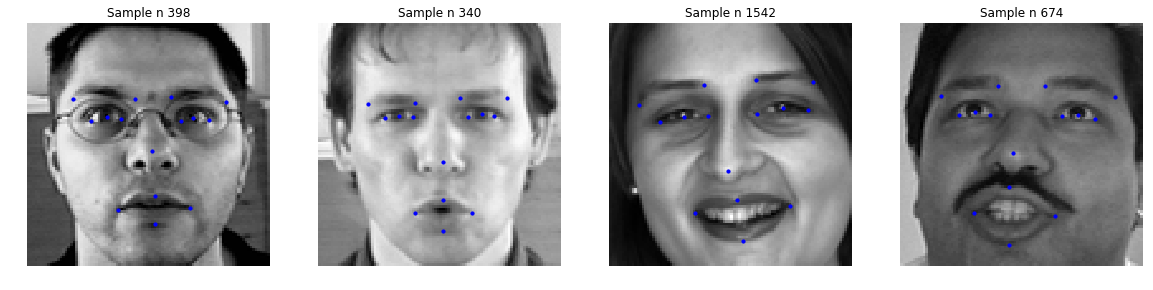

In [12]:
plot_face_Keypoints(dsets['train'])

In [13]:
nb_out = 30

In [14]:
class myconvNet(nn.Module):

    def __init__(self, image_size=(1,96,96)):
        super(myconvNet, self).__init__()  
        
        self.conv1 = nn.Conv2d(image_size[0], 24, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5)
        self.pool2 = torch.nn.MaxPool2d(2, 2)


        self.conv3 = nn.Conv2d(36, 48, kernel_size=5)
        self.pool3 = torch.nn.MaxPool2d(2, 2)


        self.conv4 = nn.Conv2d(48, 64, kernel_size=5)
        self.pool4 = torch.nn.AvgPool2d(2, 2)
        
        feature_size = self._get_conv_output(image_size)
        
        self.fc1 = nn.Linear(feature_size, 128)    
        self.drop_dense1 = torch.nn.Dropout(0.25)

        self.fc2 = nn.Linear(128, 64)
        self.drop_dense2 = torch.nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, nb_out)

        
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop_dense1(x)
        x = F.relu(self.fc2(x))
        x = self.drop_dense2(x)
        x = self.fc3(x)
        return x
    
    
    def _forward_features(self, x): 
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)     
        return x
    
    
    def _get_conv_output(self, shape):
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size
    

In [15]:
myconvNet = myconvNet()
if use_gpu:
    myconvNet = myconvNet.cuda()

In [16]:
print(myconvNet)

myconvNet (
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv4): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool4): AvgPool2d (size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  (fc1): Linear (256 -> 128)
  (drop_dense1): Dropout (p = 0.25)
  (fc2): Linear (128 -> 64)
  (drop_dense2): Dropout (p = 0.5)
  (fc3): Linear (64 -> 30)
)


In [17]:
def evaluate_model(loader, model, loss_fn, use_gpu = False):
    
    total_loss = 0
    for i, data in enumerate(loader):     
        inputs, labels = data['image'], data['keypoints']
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        # forward pass
        outputs = model(inputs)
        
        # loss
        loss = loss_fn(outputs, labels)
        
        # metrics
        total_loss += loss.data[0]
            
    return (total_loss / i)

In [18]:
def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    history_loss = []
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    patience_count= 0
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            inputs, labels = data['image'], data['keypoints']
            inputs, labels = Variable(inputs), Variable(labels)
            predict = model(inputs)
            
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(evaluate_model(train_loader, model,loss_fn) )
        loss_test.append( evaluate_model(test_loader, model,loss_fn) )
        history_loss.append(loss.data[0])
        
        print('Epoch:', epoch, ' Loss Train: ', loss_train[-1],  ' Lost Test: ', loss_test[-1])

        #Early stopping
        if(best_test_acc < loss_test[-1]):
            patience_count = 0
            best_test_acc = loss_test[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('Done!')
    return history_loss, loss_train, loss_train, model 

In [19]:
loss_fn = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(myconvNet.parameters()) 
optimizer =  optim.RMSprop(myconvNet.parameters(), lr=1e-3)
#lr = 0.1
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
num_epochs = 5
patience = 2

In [20]:
params = {'model' : myconvNet, 
        'train_loader':dset_loaders['train'],
         'test_loader':dset_loaders['valid'],
         'num_epochs': num_epochs,
         'loss_fn': loss_fn,
        'optimizer': optimizer, 
         'patience': patience 
         }

In [21]:
history_loss, loss_train, loss_train, model   = train(**params)

Epoch: 0  Loss Train:  0.020075535345258133  Lost Test:  0.02507231632868449
Epoch: 1  Loss Train:  0.014085492584854364  Lost Test:  0.01664823495472471
Epoch: 2  Loss Train:  0.011969365066651142  Lost Test:  0.012988319154828787
Epoch: 3  Loss Train:  0.011332768481224775  Lost Test:  0.014265730511397123
Done!


In [22]:
def predict(model, dset_loaders, use_gpu = False):

    predictions = []
    if use_gpu:
        use_gpu = torch.cuda.is_available()

    model.train(False)  # Set model to evaluate mode
    ii_n = len(dset_loaders)
    for ii, data in enumerate(dset_loaders):
        image, labels = data['image'], data['keypoints']
        if use_gpu:
            image = Variable(image.cuda())
        else:
            image = Variable(image)
        outputs = model.forward(image)
        predictions.append(outputs.data.cpu())
        print('\rpredict: {}/{}'.format(ii, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return torch.cat(predictions, 0)

In [23]:
preds_test = predict(myconvNet, dset_loaders['test'])
preds_train = predict(myconvNet, dset_loaders['train'])

predict: 55/55 ok
predict: 66/66 ok


In [24]:
(preds_test.shape, preds_train.shape)

(torch.Size([1783, 30]), torch.Size([2140, 30]))

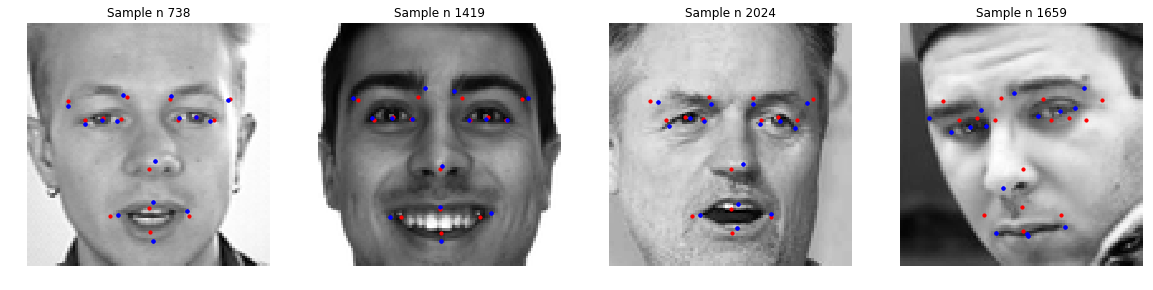

In [25]:
plot_face_Keypoints(dsets['train'],  preds_train = preds_train)

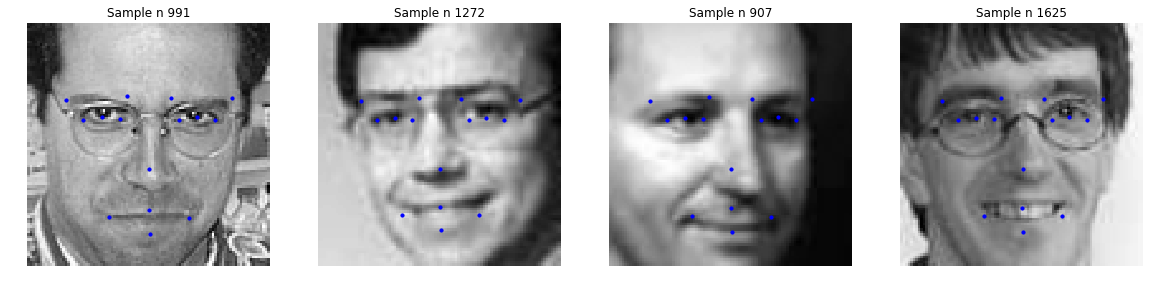

In [26]:
plot_face_Keypoints(dsets['test'], is_train= False,  preds_test = preds_test)

In [66]:
id_lookup_frame = pd.read_csv(path2data + "IdLookupTable.csv")
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

,ImageId,FeatureName
0,1,left_eye_center_x
1,1,left_eye_center_y
2,1,right_eye_center_x
3,1,right_eye_center_y
4,1,left_eye_inner_corner_x


In [60]:
y_test= preds_test.numpy() * 48  + 48
columns = dsets['train'].df.columns[:-1]

In [64]:
def generate_output_submission(y_test, columns, filename = "result.csv"):
    y_res = []
    j = 0
    k = 0
    m = 0
    for i in range(1, len(y_test)+1):
        img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
        if img.shape[0] == 30:
            y_res += list(y_test[i-1,:])
            j += 30
        else:
            slice_img = y_test[i-1, :]
            y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
            k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
    y_res = np.array(y_res)

    
    result_dict = {
    "RowId": range(1,y_res.shape[0]+1),
    "Location": y_res
    }
    result_df = pd.DataFrame(result_dict, )
    result_df.to_csv(filename, index=False, columns=["RowId", "Location"])
    print('Done!')

In [65]:
generate_output_submission(y_test, columns)

Done!
